In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/VortexModels")
Pkg.add("JLD")
Pkg.add("FileIO")

using Revise
using ViscousFlow
import ViscousFlow.Bodies: RigidTransform
using ProgressMeter
using LinearAlgebra
import LinearAlgebra: dot
using ColorSchemes
using Statistics
using Interpolations
using SparseArrays
using Plots
using JLD
using FileIO

  Updating registry at `C:\Users\nitin\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [======>                                  ]  14.7 %>                         ]  35.6 %Fetching: [=====================>                   ]  50.2 % [=====================>                   ]  51.6 %]  66.1 %Fetching: [===========================>             ]  66.6 %       ]  81.2 % Resolving package versions...
 Installed Distributions ─ v0.23.1
  Updating `C:\media\mat\HDD\VortexModels\Project.toml`
 [no changes]
  Updating `C:\media\mat\HDD\VortexModels\Manifest.toml`
  [31c24e10] ↑ Distributions v0.23.0 ⇒ v0.23.1
 Resolving package versions...
  Updating `C:\media\mat\HDD\VortexModels\Project.toml`
 [no changes]
  Updating `C:\media\mat\HDD\VortexModels\Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file C:\Users\nitin\.julia\compiled\v1.1\ViscousFlow\2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1184
┌ Warning: Module Compat with build ID 82293520177800 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Warning: Module Compat with build ID 82293520177800 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Warning: Module Compat with build ID 82293520177800 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Warning: Module Compat with build ID 82293520177800 is missing from the cache.
│ This may mean Compat [34da218

┌ Error: evaluation error starting at C:\Users\nitin\.julia\packages\DiffResults\FsQMZ\src\DiffResults.jl:235
│   mod = Main.DiffResults
│   ex = begin
    #= C:\Users\nitin\.julia\packages\DiffResults\FsQMZ\src\DiffResults.jl:235 =#
    function derivative!(f, r::ImmutableDiffResult, x::StaticArray, ::Type{Val{i}}=Val{1}) where i
        #= C:\Users\nitin\.julia\packages\DiffResults\FsQMZ\src\DiffResults.jl:236 =#
        return derivative!(r, map(f, x), Val{i})
    end
end
│   exception = (UndefVarError(:StaticArray), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x000000043a2de8d5, Ptr{Nothing} @0x000000043a2af057, Ptr{Nothing} @0x000000043a2ff632, Ptr{Nothing} @0x000000043a41409a, Ptr{Nothing} @0x0000000002178960])
└ @ Revise C:\Users\nitin\.julia\packages\Revise\SZ4ae\src\lowered.jl:106
┌ Warning: Module Compat with build ID 82293520177800 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by 

In [5]:
import Base: *, diff
pyplot()
clibrary(:colorbrewer)
default(grid = false)

# Functions for Flapping Wing Kinematics

In [6]:
struct TriangleWave <: RigidBodyMotions.Profile
    w::Float64
    round_factor::Float64
end

(T::TriangleWave)(t) = 1/(1-2/pi*acos(1-T.round_factor))*(1-2/pi*acos((1-T.round_factor)*sin(T.w*t - pi/2)))

In [7]:
struct SquareWave <: RigidBodyMotions.Profile
    w::Float64
    round_factor::Float64
end

(s::SquareWave)(t) = 1/atan(1/s.round_factor)*atan(sin(s.w*t)/s.round_factor)

In [8]:
struct PitchHeaveTest <: Kinematics
    "Freestream velocity"
    U₀::Float64

    "Axis of pitch rotation, relative to the plate centroid"
    a::Float64

    "Reduced frequency ``K = \\frac{\\Omega c}{2U_0}``"
    K::Float64

    "Phase lag of pitch to heave (in radians)"
    ϕ::Float64

    "Mean angle of attack"
    α₀::Float64

    "Amplitude of pitching"
    Δα::Float64

    "Amplitude of translational heaving"
    A::Float64
    
    "Sinusoidal nature of pitching/heaving"
    delta_pitch::Float64
    delta_heave::Float64

    Y::RigidBodyMotions.Profile
    Ẏ::RigidBodyMotions.Profile
    Ÿ::RigidBodyMotions.Profile

    α::RigidBodyMotions.Profile
    α̇::RigidBodyMotions.Profile
    α̈::RigidBodyMotions.Profile
    
end

In [9]:
function PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A)
    p = A*RigidBodyMotions.Sinusoid(2K)
    ṗ = d_dt(p)
    p̈ = d_dt(ṗ)
    α = RigidBodyMotions.ConstantProfile(α₀) + Δα*(RigidBodyMotions.Sinusoid(2K) >> (ϕ/(2K)))
    α̇ = d_dt(α)
    α̈ = d_dt(α̇)
    PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, 1, 1, p, ṗ, p̈, α, α̇, α̈)
end

PitchHeaveTest

In [10]:
function PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, delta_pitch, delta_heave)
    p = A*TriangleWave(2K, delta_heave)
    ṗ = d_dt(p)
    p̈ = d_dt(ṗ)
    # α = RigidBodyMotions.ConstantProfile(α₀) + Δα*(SquareWave(2K, delta_pitch) >> (ϕ/(2K)))
    α = RigidBodyMotions.ConstantProfile(α₀) + Δα*(SquareWave(2K, delta_pitch))
    α̇ = d_dt(α)
    α̈ = d_dt(α̇)
    PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, delta_pitch, delta_heave, p, ṗ, p̈, α, α̇, α̈)
end

PitchHeaveTest

In [11]:
function (p::PitchHeaveTest)(t)
    α = p.α(t)
    α̇ = p.α̇(t)
    α̈ = p.α̈(t)

    c = p.U₀*t + im*p.Y(t) - p.a*exp(im*α)
    ċ = p.U₀ + im*p.Ẏ(t) - p.a*im*α*exp(im*α)*α̇ 
    c̈ = im*p.Ÿ(t) - p.a*im*α̇ *exp(im*α)*α̇  + p.a*α^2*exp(im*α)*α̇ ^2 - p.a*im*α*exp(im*α)*α̈ 

    return c, ċ, c̈, α, α̇, α̈
end

# Setting Up the Body and Environment

In [12]:
Re = 200;
U = 0.0;
U∞ = (U,0.0);

n = 51;
a = 1.0; # b = 0.1;
# thicc = 0.05;
body = Plate(a, n);

In [13]:
a = 0.5 # location of pitch axis, a = 0.5 is leading edge. Try 0.1, 0.25, 0.4, and 0.5
ϕ = -pi/2  # phase lag of pitch to heave
A = 0.5  # amplitude/chord
fstar = 1.0/2 # fc/U
α₀ = 0 # mean angle of attack
Δα = 30π/180 # amplitude of pitching, try 5, 15, 30, and 45
U₀ = 0.0 # translational motion (set to zero in place of free stream)

K = π*fstar # reduced frequency, K = πfc/U

oscil = PitchHeaveTest(U₀,a,K,ϕ,α₀,Δα,A);
motion = RigidBodyMotion(oscil)



Rigid Body Motion:
  ċ = 0.0 + 1.57im
  c̈ = -0.68 + 1.17im
  α̇ = 0.0
  α̈ = -5.17
  PitchHeaveTest(0.0, 0.5, 1.5707963267948966, -1.5707963267948966, 0.0, 0.5235987755982988, 0.5, 1.0, 1.0, 0.5 × (Sinusoid (ω = 3.14)), d/dt (0.5 × (Sinusoid (ω = 3.14))), d/dt (d/dt (0.5 × (Sinusoid (ω = 3.14)))), AddedProfiles:
  Constant (0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
, d/dt (AddedProfiles:
  Constant (0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
), d/dt (d/dt (AddedProfiles:
  Constant (0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
)))

In [11]:
m = motion(0.0)

(-0.43301270189221935 - 0.24999999999999997im, 1.318463107291888e-17 + 1.5707963267948966im, -0.6764520210694611 + 1.1716492693749596im, 0.5235987755982988, 1.0072316198870592e-16, -5.167712780049969)

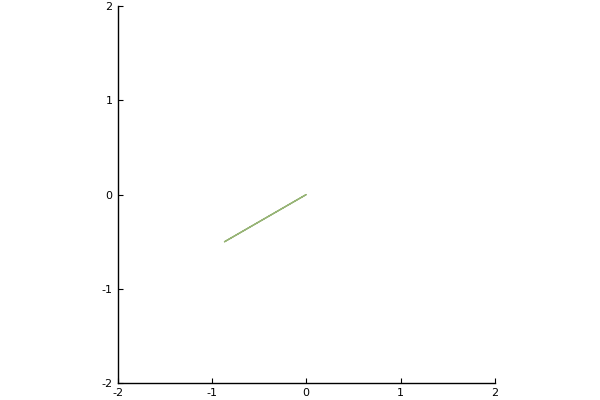

In [12]:
cent = m[1];
α = m[4];
#cent = 0.0 + 0.0*im # change to 0.0 - A*im for flapping using square and triangle waves, otherwise 0.0 + 0.0im
#α = Δα # change to -Δα for flapping using sinusoidal waves, otherwise 0.0
T = RigidTransform(cent,m[4]);
T(body) # transform the body to the current configuration

xlim = (-2.0,2.0)
ylim = (-2.0,2.0)

plot(xlim=xlim, ylim=ylim, body)


In [13]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Umax = 0.25*pi/(2*K*2*a)

Δx = 0.02;
Δt = 0.005;

In [14]:
K = body.len/length(body)/Δx;
@show K
@show body.len
@show length(body)

K = 0.9803921568627451
body.len = 1.0
length(body) = 51


51

# Setting Up the System and Solver

In [15]:
sys = Systems.NavierStokes(Re, Δx, xlim, ylim, Δt, X̃ = X̃, 
    isstore = true, 
    isstatic = false, 
    ddftype=Fields.Yang3, 
    isfilter = false)

Navier-Stokes system on a grid of size 208 x 208

In [16]:
w₀ = Nodes(Dual,size(sys));
u = (w₀,[real(motion(0.0)[1]),imag(motion(0.0)[1]), motion(0.0)[4]])
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))
f = (VectorData(X̃),Vector{Float64}());

In [17]:
using LinearAlgebra
plan_intfact1(t,u) = Fields.plan_intfact(t,u,sys)
plan_intfact2(t,u) = I
plans = (plan_intfact1,plan_intfact2)    

(plan_intfact1, plan_intfact2)

In [18]:
function TimeMarching.plan_constraints(u::Tuple{Nodes{Dual,NX,NY},Vector{Float64}},t,sys::NavierStokes{NX,NY,N,false}) where {NX,NY,N}

  # for now, just assume that there is only one body. will fix later.

  xc, yc, α = u[2]
  T = Bodies.RigidTransform((xc,yc),α)
  # should be able to save some time and memory allocation here...
  x, y = T(sys.X̃.u,sys.X̃.v)
  X = VectorData(x,y)
  regop = Regularize(X,cellsize(sys);issymmetric=true,I0=origin(sys))
  if sys._isstore
#     Hmat, Emat = RegularizationMatrix(regop,VectorData{N}(),Edges{Primal,NX,NY}())
    Hmat, Emat = RegularizationMatrix(regop, VectorData(X), Edges(Primal, u[1]))
      
    sys.Hmat = Hmat
    sys.Emat = Emat
    
    return (f->TimeMarching.B₁ᵀ(f,sys), f->zeros(Float64,size(u[2]))),
           (w->TimeMarching.B₂(w,sys), u->Vector{Float64}())
  else
    return (f->TimeMarching.B₁ᵀ(f,regop,sys), f->zeros(Float64,size(u[2]))),
           (w->TimeMarching.B₂(w,regop,sys), u->Vector{Float64}())
  end


end

In [19]:
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)
TimeMarching.r₁(u,t) = TimeMarching.r₁(u,t,sys,motion)
TimeMarching.r₂(u,t) = TimeMarching.r₂(u,t,sys,motion)
ifherk = IFHERK(u,f,sys.Δt,
                plans,plan_constraints,
                (TimeMarching.r₁,TimeMarching.r₂),rk=TimeMarching.RK31,isstored=true,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,208,208,Float64},Array{Float64,1}}
   Force of type Tuple{VectorData{51,Float64},Array{Float64,1}}
   Time step size 0.005


# Running the Solver

In [20]:
t = 0.0
w₀ .= 0.0
# u = (deepcopy(w₀),[real(cent),imag(cent),α₀])
u = (deepcopy(w₀),[real(motion(0.0)[1]),imag(motion(0.0)[1]), motion(0.0)[4]])
f = (VectorData(X̃),Vector{Float64}());
fx = Float64[];
fy = Float64[];
kin_hist = []
dp = [];
thist = [];
uhist = [];
tsample = 0.02; # rate at which to store field data
tf = 5;
T = Δt:Δt:tf;

In [21]:
@showprogress for ti in T
    global t, u, f = ifherk(t,u)
    
    push!(thist,t)
    
    fp = deepcopy(f[1])
    fp.u .*= Δx^2
    fp.v .*= Δx^2
    
    push!(dp,fp)
    push!(kin_hist, deepcopy(u[2]))
    
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)

    if (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12))
      push!(uhist, deepcopy(u))
    end

end
println("solution completed through time t = ",t)

Progress: 100%|█████████████████████████████████████████| Time: 3:14:55


solution completed through time t = 4.999999999999916


In [22]:
@show kin_hist
@show uhist

kin_hist = Any[[-0.433021, -0.242132, 0.523534], [-0.433046, -0.234237, 0.52334], [-0.433089, -0.226316, 0.523018], [-0.433148, -0.218372, 0.522566], [-0.433223, -0.210406, 0.521985], [-0.433316, -0.202422, 0.521275], [-0.433424, -0.19442, 0.520437], [-0.433549, -0.186402, 0.51947], [-0.43369, -0.178372, 0.518375], [-0.433846, -0.170331, 0.517153], [-0.434019, -0.16228, 0.515802], [-0.434206, -0.154224, 0.514325], [-0.434408, -0.146162, 0.51272], [-0.434625, -0.138098, 0.510989], [-0.434856, -0.130034, 0.509132], [-0.435101, -0.121972, 0.50715], [-0.43536, -0.113914, 0.505042], [-0.435632, -0.105863, 0.502809], [-0.435916, -0.0978206, 0.500453], [-0.436212, -0.0897891, 0.497973], [-0.43652, -0.081771, 0.49537], [-0.436839, -0.0737685, 0.492645], [-0.437169, -0.0657839, 0.489799], [-0.437509, -0.0578195, 0.486831], [-0.437858, -0.0498777, 0.483744], [-0.438216, -0.0419609, 0.480537], [-0.438583, -0.0340713, 0.477211], [-0.438958, -0.0262114, 0.473768], [-0.43934, -0.0183835, 0.470208], 

uhist = Any[(Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.433148, -0.218372, 0.522566]), (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.433549, -0.186402, 0.51947]), (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.434206, -0.154224, 0.514325]), (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.435101, -0.121972, 0.50715]), (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.436212, -0.0897891, 0.497973]), (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.437509, -0.0578195, 0.486831]), (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual no

250-element Array{Any,1}:
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.433148, -0.218372, 0.522566])  
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.433549, -0.186402, 0.51947])   
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.434206, -0.154224, 0.514325])  
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.435101, -0.121972, 0.50715])   
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.436212, -0.0897891, 0.497973]) 
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 208), [-0.437509, -0.0578195, 0.486831]) 
 (Dual nodes in a (nx = 208, ny = 208) cell grid of type Float

In [23]:
clibrary(:colorbrewer)
default(clim = (-0.25, 0.25), markerstrokealpha = 0, markersize = 3, grid = false, 
     legend = false, colorbar = :right, colorbar_title = "\$\\Gamma\$")

newanim = @animate for i = 1:length(uhist)
    T = RigidTransform(uhist[i][2])
    T(body)
    plot(xg,yg,uhist[i],levels=range(-0.5,stop=0.5,length=30), color = :RdBu)
    plot!(xlim=xlim, ylim=ylim, body)
end

gif(newanim, "Sinusoid_30_5T.gif") 

C:\Users\nitin\.julia\conda\3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


ErrorException: failed process: Process(`'C:\Users\nitin\.julia\packages\FFMPEG\guN1x\deps\usr\bin\ffmpeg.exe' -v 0 -framerate 20 -loop 0 -i 'C:\Users\nitin\AppData\Local\Temp\jl_EEA.tmp/%06d.png' -i 'C:\Users\nitin\AppData\Local\Temp\jl_EEA.tmp/palette.bmp' -lavfi paletteuse=dither=sierra2_4a -y 'C:\Users\nitin\Documents\ViscousFlow.jl-master\ViscousFlow.jl-master\Sinusoid_30_5T.gif'`, ProcessExited(1)) [1]

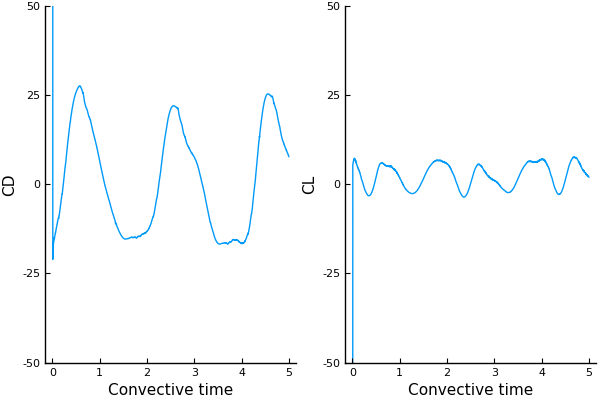

In [24]:
px = plot(thist,2*fy,ylim=(-50,50),xlabel="Convective time",ylabel="CD",legend=false)
py = plot(thist,2*fx,ylim=(-50,50),xlabel="Convective time",ylabel="CL",legend=false)
plot(px,py)

# Obtaining Pressure Distributions

In [25]:
RigidTransform(kin::Kinematics, t) = RigidTransform(kin(t)[1], kin(t)[4])

RigidTransform

In [26]:
function diff(b::Body{N}) where {N}
  ip1(i) = 1 + mod(i,N)
  im1(i) = 1 + mod(i-2,N)
  dxtmp = [0.5*(b.x[ip1(i)] - b.x[im1(i)]) for i = 1:N]
  dytmp = [0.5*(b.y[ip1(i)] - b.y[im1(i)]) for i = 1:N]

  if typeof(body) <:Plate
    dxtmp[1] = 0.5*(b.x[2] - b.x[1])
    dxtmp[N] = 0.5*(b.x[N] - b.x[N-1])

    dytmp[1] = 0.5*(b.y[2] - b.y[1])
    dytmp[N] = 0.5*(b.y[N] - b.y[N-1])
  end
  return dxtmp,dytmp
end

diff (generic function with 10 methods)

In [27]:
ds = sqrt.(diff(body)[1].^2+diff(body)[2].^2);

In [28]:
q = Edges(Primal,u[1])
f = VectorData(X)

regop = Regularize(X,Δx;I0=Fields.origin(sys.grid),issymmetric=true)
Hmat, Emat = RegularizationMatrix(regop,f,q)

regopfilt = Regularize(X,Δx;I0=Fields.origin(sys.grid),filter=true,weights=Δx^2)
Ēmat = InterpolationMatrix(regopfilt,q,f)
# Cmat = sparse(Ēmat*Hmat);
P(f) = Ēmat*(Hmat*f)

P (generic function with 1 method)

In [29]:
normal(β) = (-sin(β), cos(β))

normal (generic function with 1 method)

In [30]:
function dot(A::Tuple{T,T},B::VectorData) where {T<:Number}
    C = ScalarData(B)
    x, y = A
    C.data .= x*B.u + y*B.v
    return C
end

dot (generic function with 22 methods)

In [31]:
length(kin_hist)

1000

In [32]:
pressure = []
Fn = []
@showprogress for (i, dpi) in enumerate(dp)
    xc, yc, α = kin_hist[i]
#     n = (-sin(α), cos(α))
    
    T = Bodies.RigidTransform((xc,yc),α)
    # should be able to save some time and memory allocation here...
    x, y = T(sys.X̃.u,sys.X̃.v)
    X = VectorData(x,y)
    
    regop = Regularize(X,Δx;I0=Fields.origin(sys.grid),issymmetric=true)
    Hmat, Emat = RegularizationMatrix(regop,f,q)

    regopfilt = Regularize(X,Δx;I0=Fields.origin(sys.grid),filter=true,weights=Δx^2)
    Ēmat = InterpolationMatrix(regopfilt,q,f)

    
    push!(pressure, deepcopy(dot(normal(α), (Ēmat*(Hmat*dpi))) ./(K*Δx)))
    push!(Fn, deepcopy([(-fx*sin(α)+fy*cos(α))]))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:05


In [33]:
length(pressure[1])

51

0.1
0.2
0.3
0.4
0.5
0.6
0.7000000000000001
0.8
0.8999999999999999
1.0
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.7999999999999998
1.9
2.0
2.1
2.1999999999999997
2.3
2.4
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.5999999999999996
3.6999999999999997
3.8
3.9
4.0
4.1000000000000005
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.8999999999999995
6.0
6.1
6.2
6.3
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.000000000000001
7.1
7.199999999999999
7.3
7.3999999999999995
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.7
8.799999999999999
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.700000000000001
9.8
9.9
10.0
10.100000000000001
10.2
10.299999999999999
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.200000000000001
11.3
11.4
11.5
11.600000000000001
11.700000000000001
11.799999999999999
11.899999999999999
12.0
12.

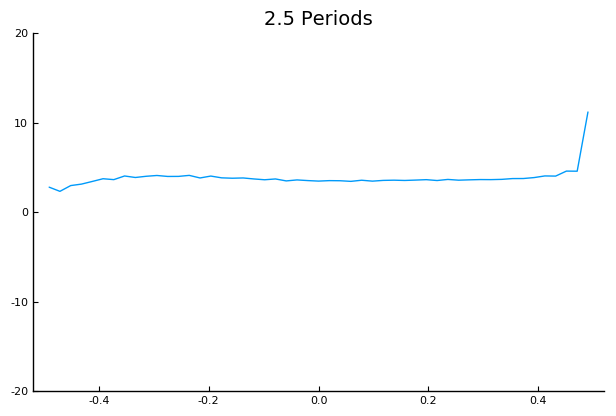

┌ Info: Saved animation to 
│   fn = C:\Users\nitin\Documents\ViscousFlow.jl-master\ViscousFlow.jl-master\Sinusoid_30_5T_p.gif
└ @ Plots C:\Users\nitin\.julia\packages\Plots\2KhB2\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\nitin\\Documents\\ViscousFlow.jl-master\\ViscousFlow.jl-master\\Sinusoid_30_5T_p.gif")
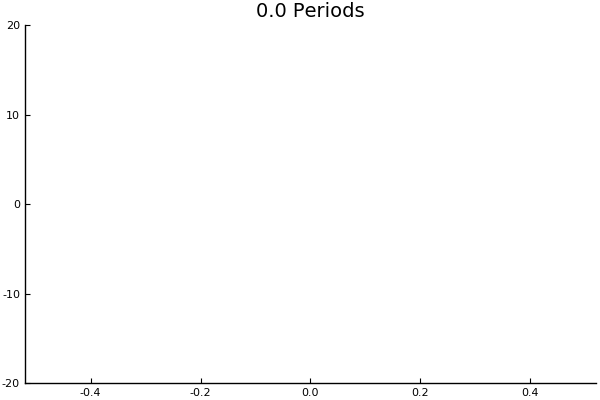

In [34]:
time = Δt:Δt:tf;

newanim2 = @animate for i = 1:length(kin_hist)
    println(i/length(kin_hist)*100)
    plot(K*body.x̃, pressure[i], ylim = (-20, 20), title = string(string(round(time[i]*fstar*100)/100), " Periods"))
end

gif(newanim2, "Sinusoid_30_5T_p.gif") 

In [35]:
s = K*body.x̃;
t = time;
p = pressure;

In [36]:
@save "Re_200_Sinusoid.jld2" s t p fx fy Fn